# Machine Learning Prediction of Nonlinear Dynamical Systems

## implementation of the paper "Machine-learning potential of a single pendulum"
Authors: Swarnendu Mandal, Sudeshna Sinha, Manish Dev Shrimali  
*Central University of Rajasthan & IISER Mohali*

Using RC for two seperate tasks that is to predict the dynamics of:
1. A driven damped pendulum system
2. The Lorenz attractor system

Running Ridge-0: 100%|██████████| 200/200 [00:00<00:00, 73243.76it/s]


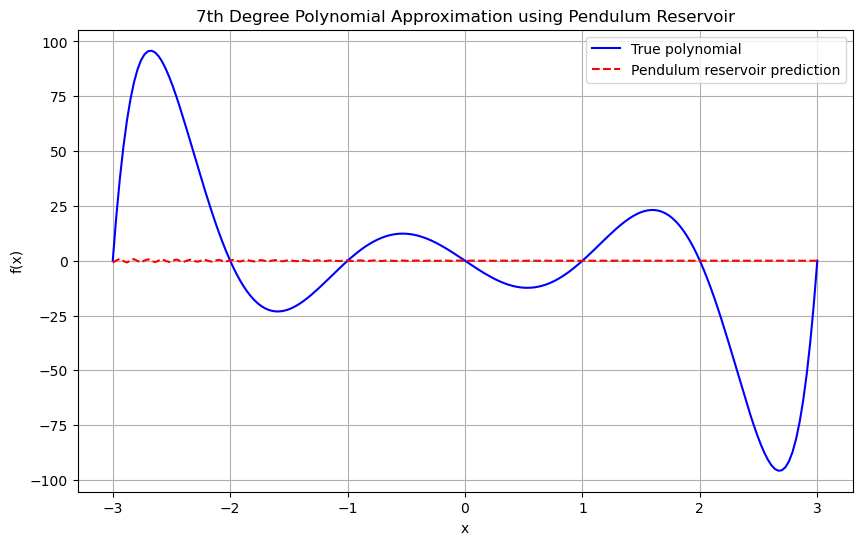

In [3]:
from reservoirpy.nodes import Reservoir
from reservoirpy.nodes import Ridge

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

g = 9.81  # gravity
k = 0.1  # damping
l = 1.0  # length



# Define the pendulum system
def pendulum_system(state, t):
    theta, omega = state
    dtheta = omega
    domega = -(g/l)*np.sin(theta) - k*omega  # using g, l, k from existing variables
    return [dtheta, domega]

# Define the 7th degree polynomial function (target)
def target_function(x):
    return (x - 3) * (x - 2) * (x - 1) * x * (x + 1) * (x + 2) * (x + 3)

x_train = np.linspace(-3, 3, 1000).reshape(-1, 1)
y_train = target_function(x_train)

t = np.linspace(0, 100, 1000)
initial_state = [0.1, 0]  # using existing initial state
pendulum_states = odeint(pendulum_system, initial_state, t)

# Use pendulum states as reservoir states
reservoir_states = pendulum_states

# Train a simple linear readout
readout = Ridge(ridge=1e-6)
readout.fit(reservoir_states, y_train)

# Generate test points
x_test = np.linspace(-3, 3, 200).reshape(-1, 1)
test_states = odeint(pendulum_system, initial_state, np.linspace(0, 100, 200))
y_pred = readout.run(test_states)
y_true = target_function(x_test)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_test, y_true, 'b-', label='True polynomial')
plt.plot(x_test, y_pred, 'r--', label='Pendulum reservoir prediction')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('7th Degree Polynomial Approximation using Pendulum Reservoir')
plt.legend()
plt.grid(True)


Running Model-14: 9999it [00:01, 6925.08it/s]<?, ?it/s]
Running Model-14: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Fitting node Ridge-15...


Running Model-14: 2000it [00:00, 7479.44it/s]          


-52.388877769292094
(2000, 3)
27.923120832496316


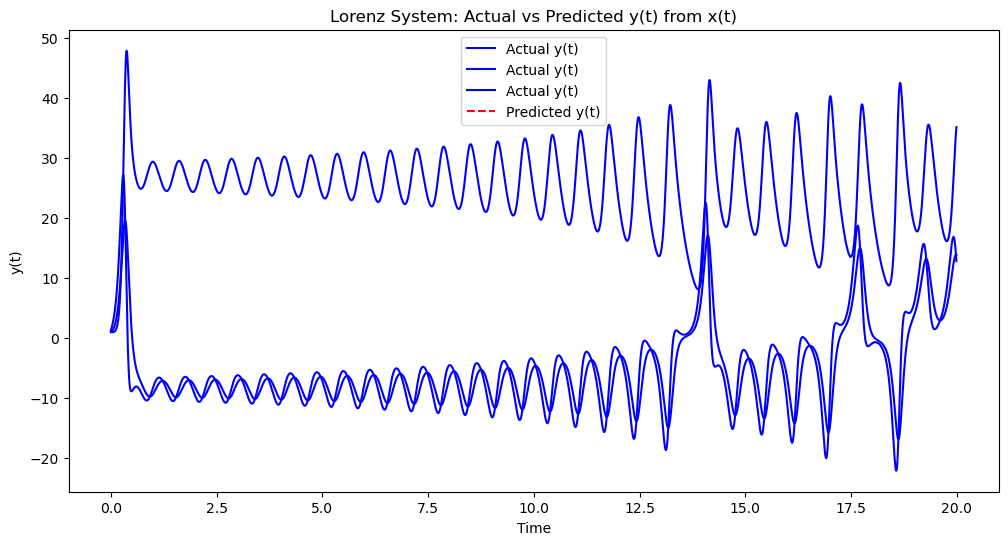

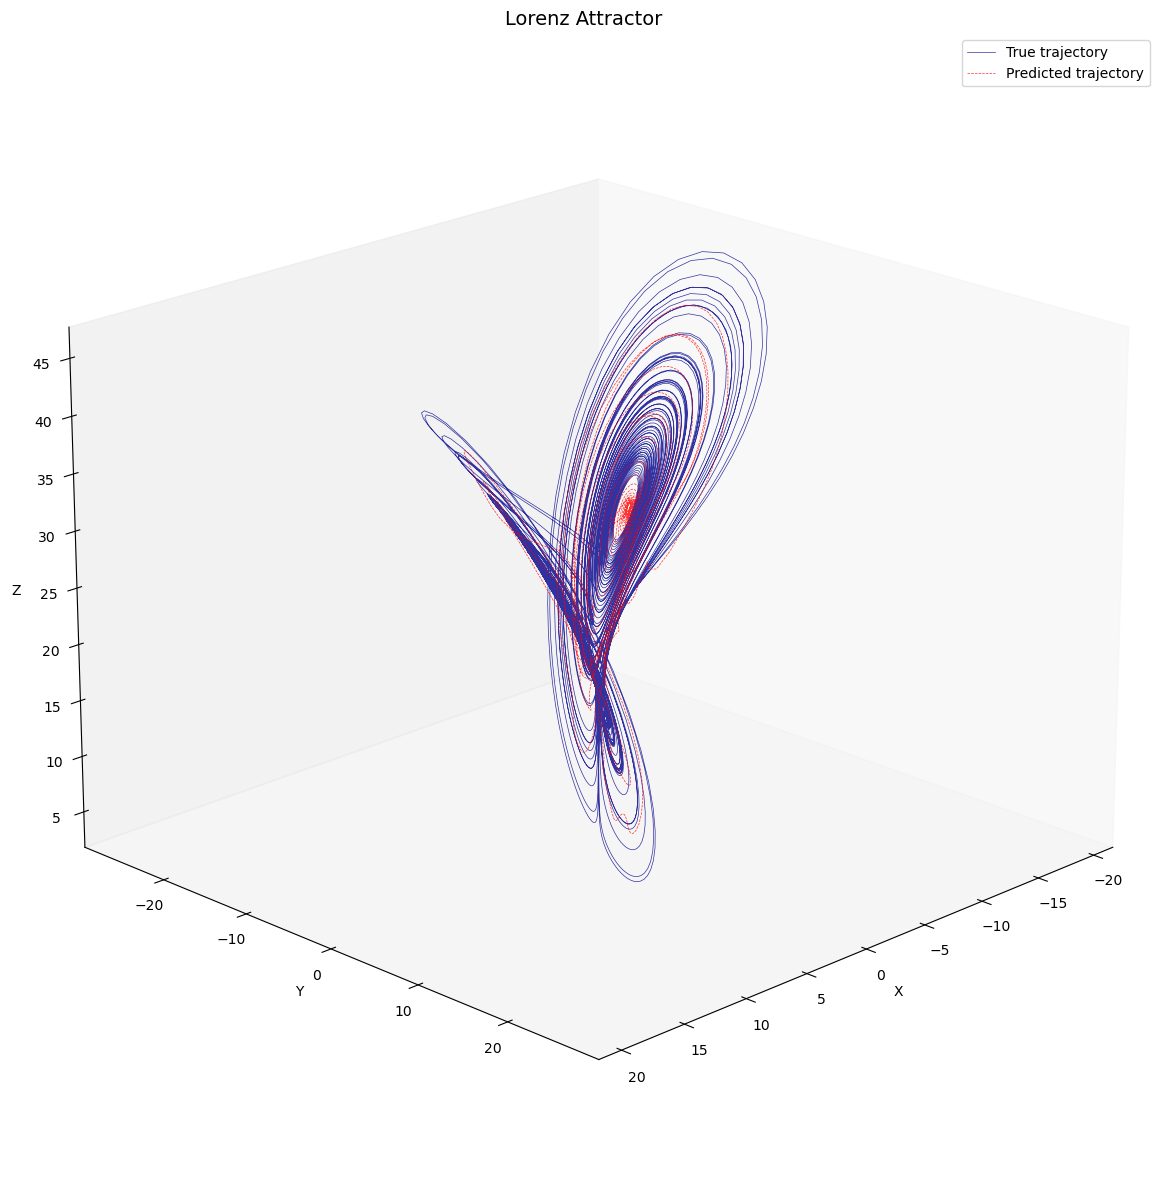

In [18]:
# Generate Lorenz data
def lorenz_system(state, t):
    x, y, z = state
    dx = 10 * (y - x)
    dy = x * (28 - z) - y
    dz = x * y - (8/3) * z
    return [dx, dy, dz]

#generating data
t_lorenz = np.linspace(0, 100, 10000)
initial_state_lorenz = [1, 1, 1]
solution_lorenz = odeint(lorenz_system, initial_state_lorenz, t_lorenz)

# input and output data
X_lorenz = solution_lorenz[:-1, 0].reshape(-1, 1)  # x component as input
y_lorenz = solution_lorenz[1:, :]  # all components as target

# Create and configure new reservoir for Lorenz task
reservoir_lorenz = Reservoir(
    units=500,
    lr=0.3,
    sr=0.9,
    input_scaling=0.5,
    bias_scaling=0.1
)

readout_lorenz = Ridge(ridge=1e-6)
model_lorenz = reservoir_lorenz >> readout_lorenz

# Train the model to predict all components
model_lorenz.fit(X_lorenz, y_lorenz)

# Make predictions
pred_lorenz = model_lorenz.run(X_lorenz[:2000])
print(pred_lorenz[0][-1])
# pred_lorenz = model_lorenz.run(pred_lorenz[1999:2000, 0])

# for _ in range(1000):
#     pred_lorenz = np.append(pred_lorenz, model_lorenz.run(pred_lorenz[-1].reshape(1, 1)))

print(pred_lorenz.shape)

print(pred_lorenz[0][0])
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(t_lorenz[:2000], y_lorenz[:2000], 'b-', label='Actual y(t)')
plt.plot(t_lorenz[:1], pred_lorenz[0][0], 'r--', label='Predicted y(t)')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.legend()
plt.title('Lorenz System: Actual vs Predicted y(t) from x(t)')

plt.figure(figsize=(15, 12))
ax = plt.axes(projection='3d')
# Plot true values with a solid line
ax.plot3D(solution_lorenz[100:-100, 0], solution_lorenz[100:-100, 1], solution_lorenz[100:-100, 2], 
          lw=0.5, c='darkblue', alpha=0.8, label='True trajectory')
# Plot predicted values with a dashed line
ax.plot3D(pred_lorenz[100:-100, 0], pred_lorenz[100:-100, 1], pred_lorenz[100:-100, 2],
          lw=0.5, c='red', linestyle='--', alpha=0.8, label='Predicted trajectory')
ax.legend()

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz Attractor', fontsize=14)

ax.view_init(elev=20, azim=45)

ax.grid(False)
plt.tight_layout()

In [6]:
import numpy as np
from scipy.integrate import odeint
from reservoirpy import Node
from reservoirpy.nodes import Ridge
from typing import Tuple, Optional
import matplotlib.pyplot as plt

class LogisticMapReservoir(Node):
    def __init__(self, 
                 P: int,
                 a_min: float,
                 a_max: float,
                 u_min: float, 
                 u_max: float,
                 memory: int = 100,
                 noise_level: float = 0.0,
                 temporal: bool = True,
                 name: Optional[str] = None):
        """
        Enhanced logistic map reservoir implementing both temporal and non-temporal tasks.
        
        Args:
            P: Number of iterations for each input
            a_min: Minimum value for logistic map parameter
            a_max: Maximum value for logistic map parameter 
            u_min: Minimum input value
            u_max: Maximum input value
            memory: Memory parameter for temporal tasks
            noise_level: Noise strength to add to inputs
            temporal: Whether to use temporal processing with memory
            name: Name of the node
        """
        super().__init__(name=name)
        self.P = P
        self.a_min = a_min
        self.a_max = a_max
        self.u_min = u_min
        self.u_max = u_max
        self.memory = memory
        self.noise_level = noise_level
        self.temporal = temporal
        self.w0 = 0.95
        
        # Initialize memory buffer for temporal tasks
        if temporal:
            self.memory_buffer = []
            # Generate memory weights as described in paper
            self.memory_weights = np.linspace(0, 1, memory)
        
    def get_param_a(self, u: float) -> float:
        """Convert input to logistic map parameter."""
        return self.a_min + ((self.a_max - self.a_min) / 
                           (self.u_max - self.u_min)) * (u - self.u_min)
    
    def logistic_iterate(self, a: float, w0: float = 0.95) -> np.ndarray:
        """Iterate logistic map P times."""
        w = np.zeros(self.P)
        w[0] = w0
        for i in range(1, self.P):
            w[i] = a * w[i-1] * (1 - w[i-1])
        return w
    
    def get_temporal_state(self, current_state: np.ndarray) -> np.ndarray:
        """Create temporal state vector using memory."""
        if len(self.memory_buffer) < self.memory:
            # Pad with zeros if not enough history
            past_states = [np.zeros_like(current_state)] * (self.memory - len(self.memory_buffer))
            past_states.extend(self.memory_buffer)
        else:
            past_states = self.memory_buffer[-self.memory:]
            
        # Weight the states according to their temporal distance
        weighted_states = [w * state for w, state in zip(self.memory_weights, past_states)]
        return np.concatenate(weighted_states + [current_state])
    
    def call(self, x: np.ndarray) -> np.ndarray:
        """Transform input using logistic map iterations."""
        if x.ndim == 1:
            x = x.reshape(-1, 1)
            
        if self.noise_level > 0:
            x = x + np.random.uniform(-self.noise_level, self.noise_level, x.shape)
            
        output = []
        for i in range(x.shape[0]):
            # Get parameter a for current input
            a = self.get_param_a(x[i, 0])
            # Get logistic map iterations
            w = self.logistic_iterate(a)
            
            if self.temporal:
                # Store state in memory buffer
                self.memory_buffer.append(w)
                if len(self.memory_buffer) > self.memory:
                    self.memory_buffer.pop(0)
                # Get temporal state
                state = self.get_temporal_state(w)
            else:
                state = w
                
            output.append(state)
            
        return np.array(output)

def create_lorenz(xyz: np.ndarray, t: float, s: float = 10, r: float = 28, b: float = 8/3) -> np.ndarray:
    """Lorenz system equations."""
    x, y, z = xyz
    return [s*(y - x), x*(r - z) - y, x*y - b*z]

def create_rossler(xyz: np.ndarray, t: float, a: float = 0.2, b: float = 0.2, c: float = 5.7) -> np.ndarray:
    """Rossler system equations."""
    x, y, z = xyz
    return [-y - z, x + a*y, b + z*(x - c)]

def create_hindmarsh_rose(t: np.ndarray, xyz: np.ndarray) -> np.ndarray:
    """Hindmarsh-Rose system equations."""
    x, y, z = xyz
    return [y + 3*x**2 - x**3 - z + 3.25,
            1 - 5*x**2 - y,
            0.006*(4*(x + 1.6) - z)]

def generate_data(system: str, 
                 initial_conditions: Tuple[float, float, float],
                 t_start: float,
                 t_end: float,
                 dt: float) -> Tuple[np.ndarray, np.ndarray]:
    """Generate data from specified system."""
    t = np.arange(t_start, t_end, dt)
    
    if system.lower() == 'lorenz':
        sol = odeint(create_lorenz, initial_conditions, t)
    elif system.lower() == 'rossler':
        sol = odeint(create_rossler, initial_conditions, t)
    elif system.lower() == 'hindmarsh-rose':
        sol = odeint(create_hindmarsh_rose, initial_conditions, t)
    else:
        raise ValueError(f"Unknown system: {system}")
        
    return t, sol

class ReservoirPredictor:
    def __init__(self,
                 P: int = 3,
                 a_min: float = 1.0,
                 a_max: float = 2.0,
                 memory: int = 100,
                 ridge_param: float = 1e-6,
                 noise_level: float = 0.0,
                 temporal: bool = True):
        """Initialize reservoir predictor."""
        self.P = P
        self.a_min = a_min
        self.a_max = a_max
        self.memory = memory
        self.ridge_param = ridge_param
        self.noise_level = noise_level
        self.temporal = temporal
        
    def fit_predict(self, 
                    X_train: np.ndarray,
                    y_train: np.ndarray,
                    X_test: np.ndarray,
                    u_min: float,
                    u_max: float) -> np.ndarray:
        """Fit reservoir and predict."""
        logistic_reservoir = LogisticMapReservoir(
            P=self.P,
            a_min=self.a_min,
            a_max=self.a_max,
            u_min=u_min,
            u_max=u_max,
            memory=self.memory,
            noise_level=self.noise_level,
            temporal=self.temporal
        )
        
        readout = Ridge(ridge=self.ridge_param)
        model = logistic_reservoir >> readout
        
        # Initialize model with first samples
        model.initialize(X_train[0:1], y_train[0:1])
        
        # Fit the model
        model.fit(X_train, y_train, warmup=10)
        
        # Run prediction
        return model.run(X_test)

def evaluate_prediction(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[float, float]:
    """Calculate RMSE and NRMSE as per paper."""
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    nrmse = rmse / np.sqrt(np.mean((y_pred - np.mean(y_pred)) ** 2))
    return rmse, nrmse

# Example usage for temporal prediction of Lorenz system
if __name__ == "__main__":
    # Generate data
    t, data = generate_data(
        system='lorenz',
        initial_conditions=(25, 18, 120),
        t_start=40,  # As per paper
        t_end=100,
        dt=0.01
    )
    
    # Training window as per paper (t=40 to t=49.99)
    train_mask = (t >= 40) & (t < 50)
    test_mask = (t >= 50) & (t < 100)
    
    X_train = data[train_mask, 0].reshape(-1, 1)
    y_train = data[train_mask, 1].reshape(-1, 1)
    X_test = data[test_mask, 0].reshape(-1, 1)
    y_test = data[test_mask, 1].reshape(-1, 1)
    
    # Create predictor with paper parameters
    predictor = ReservoirPredictor(
        P=3,
        a_min=1.0,
        a_max=2.0,
        memory=100,
        ridge_param=1e-6,
        noise_level=0.01,
        temporal=True
    )
    
    # Predict
    y_pred = predictor.fit_predict(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        u_min=-17,
        u_max=17
    )
    
    # Evaluate
    rmse, nrmse = evaluate_prediction(y_test, y_pred)
    print(f"RMSE: {rmse:.6f}")
    print(f"NRMSE: {nrmse:.6f}")
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(t[test_mask], y_test, 'g-', label='Target')
    plt.plot(t[test_mask], y_pred, 'r--', label='Prediction')
    plt.xlabel('Time')
    plt.ylabel('y(t)')
    plt.title('Lorenz System Prediction')
    plt.legend()
    plt.show()

TypeError: 'NoneType' object is not callable